In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
from utils import *
from tqdm import tqdm
import argparse
import multiprocessing as mp

In [3]:
import sys; sys.argv=['']; del sys
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UserWarning)
if os.path.exists('./best_model.pt'):
    print('Remove last time training files')
    os.remove('./best_model.pt')

Remove last time training files


In [4]:
parser = argparse.ArgumentParser(description='Training GCN on Cora/CiteSeer/PubMed/Reddit Datasets')

'''
    Dataset arguments
'''
parser.add_argument('--dataset', type=str, default='cora',
                    help='Dataset name: cora/citeseer/pubmed/reddit')
parser.add_argument('--nhid', type=int, default=256,
                    help='Hidden state dimension')
parser.add_argument('--epoch_num', type=int, default= 100,
                    help='Number of Epoch')
parser.add_argument('--pool_num', type=int, default= 10,
                    help='Number of Pool')
parser.add_argument('--batch_num', type=int, default= 10,
                    help='Maximum Batch Number')
parser.add_argument('--batch_size', type=int, default=512,
                    help='size of output node in a batch')
parser.add_argument('--n_layers', type=int, default=2, # in ladies they use 5
                    help='Number of GCN layers')
parser.add_argument('--n_iters', type=int, default=2,
                    help='Number of iteration to run on a batch')
parser.add_argument('--n_stops', type=int, default=200,
                    help='Stop after number of batches that f1 dont increase')
parser.add_argument('--samp_num', type=int, default=5, #512 as default for layer-wise, 5 as default for node-wise
                    help='Number of sampled nodes per layer')
parser.add_argument('--sample_method', type=str, default='graphsage',
                    help='Sampled Algorithms: ladies/fastgcn/graphsage/full')
parser.add_argument('--cuda', type=int, default=1,
                    help='Avaiable GPU ID')
parser.add_argument('--variance_reduction', type=bool, default=False,
                    help='Apply variance reduction')

_StoreAction(option_strings=['--variance_reduction'], dest='variance_reduction', nargs=None, const=None, default=False, type=<class 'bool'>, choices=None, help='Apply variance reduction', metavar=None)

In [5]:
args = parser.parse_args()
print(args)

Namespace(batch_num=10, batch_size=512, cuda=1, dataset='cora', epoch_num=100, n_iters=2, n_layers=2, n_stops=200, nhid=256, pool_num=10, samp_num=5, sample_method='graphsage', variance_reduction=False)


In [6]:
class GraphConvolution(nn.Module):
    def __init__(self, n_in, n_out, num_nodes):
        super(GraphConvolution, self).__init__()
        self.n_in  = n_in
        self.n_out = n_out
        self.linear = nn.Linear(n_in,  n_out)
        self.snapshot = torch.zeros([num_nodes, n_out], dtype=torch.float32)
        self.timer = torch.zeros([num_nodes, 1], dtype=torch.float32)
        self.c = 0.1
        self.x_ = None
        
    def forward(self, x, adj, sampled_nodes, ell):
        x = self.linear(x)
        x = torch.spmm(adj, x)
        if self.training and args.variance_reduction:
            snapshot_sampled = self.snapshot[sampled_nodes,:].to(x)
            momentum = 1-self.exp_ata_weight(self.timer[sampled_nodes,:])
            x = momentum.to(x) * x + (1-momentum.to(x)) * snapshot_sampled
            self.snapshot[sampled_nodes, :] = x.detach().cpu()
            self.timer[sampled_nodes, :] += 1
        self.x_ = x.detach().cpu().numpy()
        return F.elu(x)
    
    def exp_ata_weight(self, num_steps):
        mask = num_steps < 2
        num_steps[mask]=2 # to get rid of the warning 1/0
        gamma = self.c * num_steps / (1.0 + self.c * num_steps)
        gamma *= 1.0 - torch.sqrt((1.0 - self.c) / (num_steps * (num_steps + 1))) / self.c
        gamma[mask] = 0
        return gamma
    
class GCN(nn.Module):
    def __init__(self, nfeat, nhid, layers, dropout, num_nodes):
        super(GCN, self).__init__()
        self.layers = layers
        self.nhid = nhid
        self.gcs = nn.ModuleList()
        self.gcs.append(GraphConvolution(nfeat,  nhid, num_nodes))
        self.dropout = nn.Dropout(dropout)
        for i in range(layers-1):
            self.gcs.append(GraphConvolution(nhid,  nhid, num_nodes))
    def forward(self, x, adjs, sampled_nodes):
        for ell in range(len(self.gcs)):
            x = self.gcs[ell](x, adjs[ell], sampled_nodes[ell], ell)
            x = self.dropout(x)
        return x 
    
class SuGCN(nn.Module):
    def __init__(self, encoder, num_classes, dropout, inp, num_nodes):
        super(SuGCN, self).__init__()
        self.encoder = encoder
        self.dropout = nn.Dropout(dropout)
        self.linear  = nn.Linear(self.encoder.nhid, num_classes)
        self.out = None
    def forward(self, feat, adjs, sampled_nodes):
        x = self.encoder(feat, adjs, sampled_nodes)
        x = self.linear(x)
        self.out = x.detach().cpu().numpy()
        return F.log_softmax(x, dim=1)

In [7]:
def fastgcn_sampler(seed, batch_nodes, samp_num_list, num_nodes, lap_matrix, lap_matrix_sq, depth):    
    np.random.seed(seed)
    previous_nodes = batch_nodes
    sampled_nodes = []
    adjs  = []
    pi = np.array(np.sum(lap_matrix_sq, axis=0))[0]
    p = pi / np.sum(pi)
    for d in range(depth):
        U = lap_matrix[previous_nodes , :]
        s_num = np.min([np.sum(p > 0), samp_num_list[d]])
        after_nodes = np.random.choice(num_nodes, s_num, p = p, replace = False)
        adj = U[: , after_nodes].multiply(1/p[after_nodes])
        adjs += [sparse_mx_to_torch_sparse_tensor(row_normalize(adj))]
        sampled_nodes += [previous_nodes]
        previous_nodes = after_nodes
    sampled_nodes.reverse()
    adjs.reverse()
    return adjs, previous_nodes, batch_nodes, sampled_nodes

def ladies_sampler(seed, batch_nodes, samp_num_list, num_nodes, lap_matrix, lap_matrix_sq, depth):
    np.random.seed(seed)
    previous_nodes = batch_nodes
    sampled_nodes = []
    adjs  = []
    for d in range(depth):
        U = lap_matrix[previous_nodes , :]
        pi = np.array(np.sum(lap_matrix_sq[previous_nodes , :], axis=0))[0]
        p = pi / np.sum(pi)
        s_num = np.min([np.sum(p > 0), samp_num_list[d]])
        after_nodes = np.random.choice(num_nodes, s_num, p = p, replace = False)
        after_nodes = np.unique(np.concatenate((after_nodes, batch_nodes)))
        adj = U[: , after_nodes].multiply(1/p[after_nodes])
        adjs += [sparse_mx_to_torch_sparse_tensor(row_normalize(adj))]
        sampled_nodes += [previous_nodes]
        previous_nodes = after_nodes
    sampled_nodes.reverse()
    adjs.reverse()
    return adjs, previous_nodes, batch_nodes, sampled_nodes

# def full_sampler(seed, batch_nodes, samp_num_list, num_nodes, lap_matrix, lap_matrix_sq, depth):
#     previous_nodes = batch_nodes
#     sampled_nodes = []
#     adjs = []
#     for d in range(depth):
#         # print(previous_nodes)
#         U = lap_matrix[previous_nodes, :]
#         pi = np.sum(U, axis=0)
#         indices = np.where(pi > 0)[1]
#         after_nodes = np.unique(np.concatenate((indices, batch_nodes)))
#         adj = U[:, after_nodes]
#         adjs += [sparse_mx_to_torch_sparse_tensor(adj)]
#         previous_nodes = after_nodes
#         sampled_nodes.append(after_nodes)
#     adjs.reverse()
#     sampled_nodes.reverse()
#     return adjs, previous_nodes, batch_nodes, sampled_nodes

def full_sampler(seed, batch_nodes, samp_num_list, num_nodes, lap_matrix, lap_matrix_sq, depth):
    sampled_nodes = [np.arange(num_nodes) for d in range(depth-1)] + [batch_nodes]
    adjs = []
    for d in range(depth-1):
        adjs += [sparse_mx_to_torch_sparse_tensor(lap_matrix)]
    adjs += [sparse_mx_to_torch_sparse_tensor(lap_matrix[batch_nodes])]
    return adjs, np.arange(num_nodes), batch_nodes, sampled_nodes

def graphsage_sampler(seed, batch_nodes, samp_num_list, num_nodes, lap_matrix, lap_matrix_sq, depth):
    sampled_nodes = []
    previous_nodes = batch_nodes
    adjs = []
    for d in range(depth):
        U = lap_matrix[previous_nodes , :]
        pi = np.sum(U, axis=0).flatten()
        indices = np.where(pi > 0)[0]
        after_nodes = np.random.choice(indices, samp_num_list[d], replace=True)
        after_nodes = np.unique(np.concatenate((after_nodes, batch_nodes)))
        adj = U[:, after_nodes]
        adjs += [sparse_mx_to_torch_sparse_tensor(row_normalize(adj))]
        sampled_nodes.append(previous_nodes)
        previous_nodes = after_nodes
    adjs.reverse()
    sampled_nodes.reverse()
    return adjs, previous_nodes, batch_nodes, sampled_nodes

def default_sampler(seed, batch_nodes, samp_num_list, num_nodes, lap_matrix, lap_matrix_sq, depth):
    mx = sparse_mx_to_torch_sparse_tensor(lap_matrix)
    return [mx for i in range(depth)], np.arange(num_nodes), batch_nodes, np.arange(num_nodes)

def prepare_data(pool, sampler, process_ids, train_nodes, valid_nodes, samp_num_list, num_nodes, lap_matrix, lap_matrix_sq, depth):
    
    jobs = []
    for _ in process_ids:
        idx = torch.randperm(len(train_nodes))[:args.batch_size]
        batch_nodes = train_nodes[idx]
        p = pool.apply_async(sampler, args=(np.random.randint(2**32 - 1), batch_nodes,                                                    
                                            samp_num_list, num_nodes, lap_matrix, lap_matrix_sq, depth))
        jobs.append(p)
    idx = torch.randperm(len(valid_nodes))[:args.batch_size]
    batch_nodes = valid_nodes[idx]
    p = pool.apply_async(sampler, args=(np.random.randint(2**32 - 1), batch_nodes,                                                
                                        samp_num_list * 20, num_nodes, lap_matrix, lap_matrix_sq, depth))
    jobs.append(p)
    return jobs

def package_mxl(mxl, device):
    return [torch.sparse.FloatTensor(mx[0], mx[1], mx[2]).to(device) for mx in mxl]

In [8]:
if args.cuda != -1:
    device = torch.device("cuda:" + str(args.cuda))
else:
    device = torch.device("cpu")
    
edges, labels, feat_data, train_nodes, valid_nodes, test_nodes = preprocess_data(args.dataset)
print(edges.shape, labels.shape, feat_data.shape, train_nodes.shape, valid_nodes.shape, test_nodes.shape)

(10556, 2) (2708,) (2708, 1433) (1208,) (500,) (1000,)


In [9]:
num_classes = labels.max().item()+1

In [10]:
adj_matrix = get_adj(edges, feat_data.shape[0])
lap_matrix = normalize(adj_matrix + sp.eye(adj_matrix.shape[0]))
lap_matrix_sq = lap_matrix.multiply(lap_matrix)

if type(feat_data) == sp.lil.lil_matrix:
    feat_data = torch.FloatTensor(feat_data.todense()).to(device) 
else:
    feat_data = torch.FloatTensor(feat_data).to(device)
labels    = torch.LongTensor(labels).to(device) 

In [11]:
if args.sample_method == 'ladies':
    sampler = ladies_sampler
    samp_num_list = np.array([args.samp_num for _ in range(args.n_layers)])
elif args.sample_method == 'fastgcn':
    sampler = fastgcn_sampler
    samp_num_list = np.array([args.samp_num for _ in range(args.n_layers)])
elif args.sample_method == 'full':
    sampler = full_sampler
    samp_num_list = np.array([args.samp_num for _ in range(args.n_layers)])
elif args.sample_method == 'graphsage':
    sampler = graphsage_sampler
    samp_num_list = np.array([args.batch_size*args.samp_num**i for i in range(args.n_layers)])

In [12]:
vis_layer = 0
sample_variances = []
def cal_variance(a,b):
    var = np.abs(a - b)**2
    return np.average(var.flatten())

In [13]:
process_ids = np.arange(args.batch_num)

pool = mp.Pool(args.pool_num)
jobs = prepare_data(pool, sampler, process_ids, train_nodes, valid_nodes, samp_num_list, len(feat_data), lap_matrix, lap_matrix_sq, args.n_layers)

all_res = []
encoder = GCN(nfeat = feat_data.shape[1], nhid=args.nhid, layers=args.n_layers, dropout = 0.2, num_nodes=feat_data.shape[0]).to(device)
susage  = SuGCN(encoder = encoder, num_classes=num_classes, dropout=0.5, inp = feat_data.shape[1], num_nodes=feat_data.shape[0])
susage.to(device)

print(susage)

optimizer = optim.Adam(filter(lambda p : p.requires_grad, susage.parameters()))
best_val = 0
best_tst = -1
times = []
res   = []
train_losses_all = []
for oiter in range(5):
    cnt = 0
    print('-' * 10)
    for epoch in np.arange(args.epoch_num):
        susage.train()
        train_losses = []
        train_data = [job.get() for job in jobs[:-1]]
        valid_data = jobs[-1].get()
        pool.close()
        pool.join()
        pool = mp.Pool(args.pool_num)
        jobs = prepare_data(pool, sampler, process_ids, train_nodes, valid_nodes, samp_num_list, len(feat_data), lap_matrix, lap_matrix_sq, args.n_layers)
        for _iter in range(args.n_iters):
            for adjs, input_nodes, output_nodes, sampled_nodes in train_data:   
                adjs = package_mxl(adjs, device)
                optimizer.zero_grad()
                t1 = time.time()
                ###
#                 """
#                 sampled_embeds
#                 """
#                 susage.eval()
#                 _ = susage.forward(feat_data[input_nodes], adjs, sampled_nodes)
#                 _sampled_embeds = susage.encoder.gcs[vis_layer].x_
#                 _sampled_nodes  = sampled_nodes[vis_layer]
#                 """
#                 Get the exact embedding
#                 """
#                 exact_adjs = [sparse_mx_to_torch_sparse_tensor(lap_matrix) for _ in range(args.n_layers)]
#                 exact_adjs = package_mxl(exact_adjs, device)
#                 exact_nodes = [np.arange(len(feat_data)) for _ in range(args.n_layers)]
#                 _ = susage.forward(feat_data, exact_adjs, exact_nodes)
#                 _exact_embeds = susage.encoder.gcs[vis_layer].x_
#                 """
#                 calculate the variance
#                 """
#                 sample_variance = cal_variance(_sampled_embeds, _exact_embeds[_sampled_nodes])
#                 sample_variances.append(sample_variance)
#                 del _exact_embeds, _sampled_embeds
                """
                sampled_embeds
                """
                susage.eval()
                _ = susage.forward(feat_data[input_nodes], adjs, sampled_nodes)
                _sampled_embeds = susage.out
                _sampled_nodes  = output_nodes
                """
                Get the exact embedding
                """
                exact_adjs = [sparse_mx_to_torch_sparse_tensor(lap_matrix) for _ in range(args.n_layers)]
                exact_adjs = package_mxl(exact_adjs, device)
                exact_nodes = [np.arange(len(feat_data)) for _ in range(args.n_layers)]
                _ = susage.forward(feat_data, exact_adjs, exact_nodes)
                _exact_embeds = susage.out
                """
                calculate the variance
                """
                sample_variance = cal_variance(_sampled_embeds, _exact_embeds[_sampled_nodes])
                sample_variances.append(sample_variance)
                del _exact_embeds, _sampled_embeds
                
                """
                start training
                """
                susage.train()
                output = susage.forward(feat_data[input_nodes], adjs, sampled_nodes)
                loss_train = F.nll_loss(output, labels[output_nodes])
                loss_train.backward()
                torch.nn.utils.clip_grad_norm_(susage.parameters(), 0.2)
                optimizer.step()
                times += [time.time() - t1]
                train_losses += [loss_train.detach().tolist()]
                del loss_train
        susage.eval()
        adjs, input_nodes, output_nodes, sampled_nodes = valid_data
        adjs = package_mxl(adjs, device)
        output = susage.forward(feat_data[input_nodes], adjs, sampled_nodes)
        loss_valid = F.nll_loss(output, labels[output_nodes]).detach().tolist()
        valid_f1 = f1_score(output.argmax(dim=1).cpu(), labels[output_nodes].cpu(), average='micro')
        print(("Epoch: %d (%.1fs) Train Loss: %.2f    Valid Loss: %.2f Valid F1: %.3f") %                   
              (epoch, np.sum(times), np.average(train_losses), loss_valid, valid_f1))
        train_losses_all.extend(train_losses)
        if valid_f1 > best_val:
            torch.save(susage, './best_model.pt')
        if valid_f1 > best_val + 1e-2:
            best_val = valid_f1
            cnt = 0
        else:
            cnt += 1
        if cnt > args.n_stops // args.batch_num:
            break
    best_model = torch.load('./best_model.pt')
    best_model.eval()
    test_f1s = []
    for b in np.arange(len(test_nodes) // args.batch_size):
        batch_nodes = test_nodes[b * args.batch_size : (b+1) * args.batch_size]
        adjs, input_nodes, output_nodes, sampled_nodes = sampler(np.random.randint(2**32 - 1), batch_nodes,
                                    samp_num_list * 20, len(feat_data), lap_matrix, lap_matrix_sq, args.n_layers)
        adjs = package_mxl(adjs, device)
        output = best_model.forward(feat_data[input_nodes], adjs, sampled_nodes)
        loss_test = F.nll_loss(output, labels[output_nodes]).cpu().detach().tolist()
        test_f1 = f1_score(output.argmax(dim=1).cpu(), labels[output_nodes].cpu(), average='micro')
        test_f1s += [test_f1]
    print('Iteration: %d, Test F1: %.3f' % (oiter, np.average(test_f1)))


SuGCN(
  (encoder): GCN(
    (gcs): ModuleList(
      (0): GraphConvolution(
        (linear): Linear(in_features=1433, out_features=256, bias=True)
      )
      (1): GraphConvolution(
        (linear): Linear(in_features=256, out_features=256, bias=True)
      )
    )
    (dropout): Dropout(p=0.2)
  )
  (dropout): Dropout(p=0.5)
  (linear): Linear(in_features=256, out_features=7, bias=True)
)
----------
Epoch: 0 (0.7s) Train Loss: 1.47    Valid Loss: 1.03 Valid F1: 0.714
Epoch: 1 (1.0s) Train Loss: 0.41    Valid Loss: 0.62 Valid F1: 0.800
Epoch: 2 (1.4s) Train Loss: 0.13    Valid Loss: 0.73 Valid F1: 0.776
Epoch: 3 (1.7s) Train Loss: 0.08    Valid Loss: 0.82 Valid F1: 0.780
Epoch: 4 (2.0s) Train Loss: 0.08    Valid Loss: 0.86 Valid F1: 0.762
Epoch: 5 (2.3s) Train Loss: 0.07    Valid Loss: 0.89 Valid F1: 0.764
Epoch: 6 (2.6s) Train Loss: 0.07    Valid Loss: 0.93 Valid F1: 0.752
Epoch: 7 (2.8s) Train Loss: 0.07    Valid Loss: 0.94 Valid F1: 0.764
Epoch: 8 (3.3s) Train Loss: 0.06    Val

In [14]:
# sample_variances = []
# for i in range(400):
#     idx = np.random.permutation(np.arange(len(train_nodes)))
#     batch_nodes = train_nodes[idx][:args.batch_size]
#     adjs, input_nodes, output_nodes, sampled_nodes = sampler(np.random.randint(2**32 - 1), batch_nodes,
#                                 samp_num_list, len(feat_data), lap_matrix, lap_matrix_sq, args.n_layers)
#     adjs = package_mxl(adjs, device)

#     """
#     sampled_embeds
#     """
#     _ = best_model.forward(feat_data[input_nodes], adjs, sampled_nodes)
#     _sampled_embeds = best_model.encoder.gcs[vis_layer].x_
#     _sampled_nodes  = sampled_nodes[vis_layer]
#     """
#     Get the exact embedding
#     """
#     exact_adjs = [sparse_mx_to_torch_sparse_tensor(lap_matrix) for _ in range(args.n_layers)]
#     exact_adjs = package_mxl(exact_adjs, device)
#     exact_nodes = [np.arange(len(feat_data)) for _ in range(args.n_layers)]
#     _ = best_model.forward(feat_data, exact_adjs, exact_nodes)
#     _exact_embeds = best_model.encoder.gcs[vis_layer].x_
#     """
#     calculate the variance
#     """
#     sample_variance = cal_variance(_sampled_embeds, _exact_embeds[_sampled_nodes])
#     sample_variances.append(sample_variance)
#     del _exact_embeds, _sampled_embeds
    
sample_variances = []
for i in range(400):
    idx = np.random.permutation(np.arange(len(train_nodes)))
    batch_nodes = train_nodes[idx][:args.batch_size]
    adjs, input_nodes, output_nodes, sampled_nodes = sampler(np.random.randint(2**32 - 1), batch_nodes,
                                samp_num_list, len(feat_data), lap_matrix, lap_matrix_sq, args.n_layers)
    adjs = package_mxl(adjs, device)

    """
    sampled_embeds
    """
    _ = best_model.forward(feat_data[input_nodes], adjs, sampled_nodes)
    _sampled_embeds = best_model.out
    _sampled_nodes  = output_nodes
    """
    Get the exact embedding
    """
    exact_adjs = [sparse_mx_to_torch_sparse_tensor(lap_matrix) for _ in range(args.n_layers)]
    exact_adjs = package_mxl(exact_adjs, device)
    exact_nodes = [np.arange(len(feat_data)) for _ in range(args.n_layers)]
    _ = best_model.forward(feat_data, exact_adjs, exact_nodes)
    _exact_embeds = best_model.out
    """
    calculate the variance
    """
    sample_variance = cal_variance(_sampled_embeds, _exact_embeds[_sampled_nodes])
    sample_variances.append(sample_variance)
    del _exact_embeds, _sampled_embeds

In [15]:
if args.variance_reduction:
    sample_method= '{}-vr'.format(args.sample_method)
else:
    sample_method= '{}'.format(args.sample_method)
    
with open('{}-variance.pkl'.format(sample_method),'wb') as f:
    pkl.dump(sample_variances, f)

full [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
ladies [3.2864358, 2.9477413, 3.2874172, 3.1601672, 2.972826, 2.8891923, 3.097224, 2.9978545, 3.229133, 3.2850058]
fastgcn [3.9688342, 4.10282, 3.9738252, 4.1409297, 4.2573433, 4.3190427, 3.8566587, 3.9173496, 3.5585709, 4.261434]
graphsage [1.3816855, 1.2404925, 1.3537359, 1.3596011, 1.3789985, 1.3538254, 1.3906441, 1.314659, 1.3137695, 1.3695577]


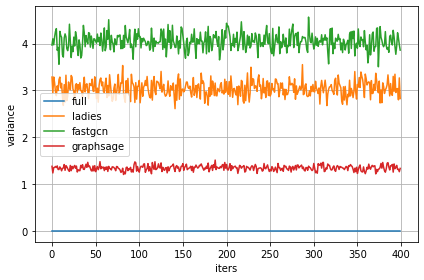

In [16]:
import matplotlib.pyplot as plt
sample_methods = ['full','ladies','fastgcn','graphsage']

fig, axs = plt.subplots()
for method in sample_methods:
    fn = '{}-variance.pkl'.format(method)
    if os.path.exists(fn):
        with open(fn,'rb') as f:
            variance = pkl.load(f)
        y = variance[:400]
        x = np.arange(len(y))
        axs.plot(x,y,label=method)
        print(method, y[:10])
        
axs.set_xlabel('iters')
axs.set_ylabel('variance')
axs.grid(True)

fig.tight_layout()
plt.legend()
plt.savefig('variance_cora.pdf')

In [17]:
susage.eval()
output = susage.forward(feat_data[input_nodes], adjs, sampled_nodes)
print(susage.encoder.gcs[0].x_.shape)

(513, 256)


In [18]:
a = np.ones([3,4])
np.sum(a,axis=1)

array([4., 4., 4.])